# Lab Six: CNNs

Team: Miro Ronac, Kirk Watson, Brandon Vincitore

Dataset Source: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [1]:
%%time
import os

import numpy as np

from PIL import Image
from numpy import asarray
from os import listdir
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

CPU times: total: 422 ms
Wall time: 481 ms


# 1. Preparation
---
##### Load in images for dataset similar to Lab 2

In [2]:
%%time
#file paths were chosen to have reasonably sized dataset
normal_dir = "chest_xray/train/NORMAL/"
pneumonia_dir = "chest_xray/test/PNEUMONIA/"

data = []
classes = []
h, w = 100, 100

#load normal images
normal_count=0
for images in os.listdir(normal_dir):
    #create image, resize to 100x100
    image = Image.open(normal_dir + images)
    image = image.resize((h,w))
    #convert image to numpy array and flatten
    data_i = asarray(image)
    #feature_i = data_i.flatten()
    #add image to list of images
    data.append(data_i)
    #store as false (not pneumonia)
    classes.append(0)
    normal_count+=1
    
#load pneumonia images
pneumonia_count=0
for images in os.listdir(pneumonia_dir):
    #create image, resize to 100x100
    image = Image.open(pneumonia_dir + images)
    image = image.resize((h,w))
    #convert image to numpy array and flatten
    data_i = asarray(image)
    #feature_i = data_i.flatten()
    #add image to list of images
    data.append(data_i)
    #store as true (pneumonia)
    classes.append(1)
    pneumonia_count+=1
    
data = np.asarray(data)
#normalize pixel data
data = data/255.0-0.5
data = np.expand_dims(data, axis=-1)

print(data.shape)
print(data.shape[0], 'total images')
print('Number of files:', len(classes))
print('Number of normal images:', normal_count, ', Number of pneumonia images:',pneumonia_count)

(1731, 100, 100, 1)
1731 total images
Number of files: 1731
Number of normal images: 1341 , Number of pneumonia images: 390
CPU times: total: 14.4 s
Wall time: 14.4 s


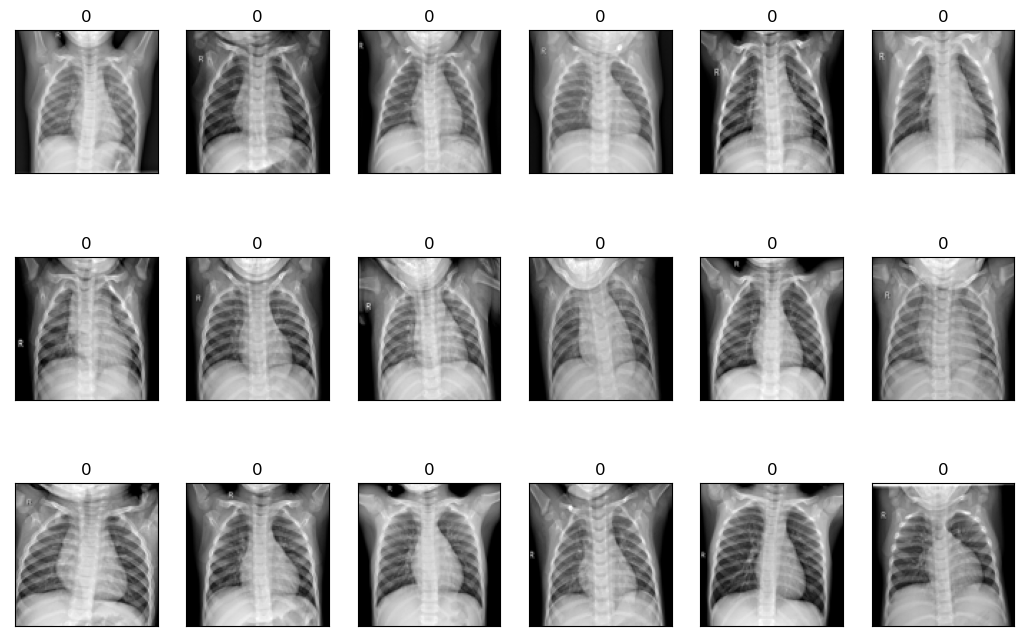

In [3]:
# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].squeeze(), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(data, classes, 100, 100)

## Evaluation metric
---
##### We chose to use the F1-score metric to account for the false negatives (recall) and false positives (precision) when evaulating our unbalanced unbalanced dataset. In the world of medicine and diagnostics, both false negatives and false positives are extremely important when evaluating a patient. We don't want to wrongly diagnose a patient with pneumonia, and we wouldn't want to wrongly diagnose a patient's lungs as healthy. With the F1-score, we have a better metric to minimize both false ocurrences. Additionally, our dataset is unbalanced in favor of normal lung images. The F1-score suits unbalanced datasets because it is calculated as a harmonic mean of precision and recall.

In [4]:
import tensorflow as tf
from tensorflow.keras import backend as K

# F1-score is no longer supported in keras so we must make a F1-score function
# From https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d

def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Divide data into training and testing
---
##### To divide our data into training and testing, we will use Stratified K-fold cross validation. We chose this method because we need to account for the imbalance of normal images and pneumonia images. A stratified split will create folds with balanced occurences of normal and pneumonia images. Using a K-fold split is beneficial for our small dataset because it will better assist our model with generalization. A K-fold split will help reduce variance and allow the model to fit with each fold.

In [5]:
from sklearn.model_selection import StratifiedKFold

X = data
y = np.asarray(classes)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# 2. Modeling
---
## Data Expansion
---
##### For data augmentation, we are using the keras ImageDataGenerator. We chose this method as a preprocessing technique to shift image heights and widths as well as rotate images. Shifting images can possibly remove unwanted effects of non-uniform image shapes before processing. Including a small rotational adjustment can resemble x-ray images that were not positioned the same as other images but still share a similar orientation. We did not flip images because our dataset images all have similar orientations such as heart position and body structure.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05)

datagen.fit(X)

In [46]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

## Model 1 - Basic CNN

In [8]:
def plot_histories(histories):
    plt.figure(figsize=(20,20))
    for fold_no, history in enumerate(histories):
        keys = list(history.history.keys())
        
        plt.subplot(5,3,3*fold_no+1)
        plt.plot(history.history[keys[0]])
        plt.title('Loss function')
        plt.ylabel('Fold #'+str(fold_no+1))

        plt.subplot(5,3,3*fold_no+2)
        plt.plot(history.history[keys[1]])
        plt.title('Eval Metric')
        plt.ylim(0.5, 1)

In [9]:
def model_1(optimizer, num_filt_layers, l2_lambda):
    reg = l2(l2_lambda)
    cnn = Sequential()
    
    for num_filters in num_filt_layers:
        cnn.add( Conv2D(filters=num_filters, 
                        kernel_size=(3,3), 
                        kernel_initializer='he_uniform', 
                        kernel_regularizer=reg,
                        padding='same',))
        cnn.add( Activation('relu'))
        cnn.add(BatchNormalization())
        cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    # add one layer on flattened output
    cnn.add( Flatten() )
    
    cnn.add( Dropout(0.25) )
    cnn.add(Dense(units=128,
                  activation='relu',
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=reg))
    
    cnn.add( Dropout(0.5) )
    cnn.add(Dense(units=1,
                  activation='sigmoid',
                  kernel_initializer='glorot_uniform',
                  kernel_regularizer=reg))

    # Let's train the model 
    cnn.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=[f1])    
    return cnn

In [10]:
def build_model_1(optimizer, num_filt_layers, l2_lambda,
                 
                 batch_size=128, epochs=15, verbose=1):
    fold_no = 0
    histories = []
    eval_scores = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cnn = model_1(optimizer, num_filt_layers, l2_lambda)

        print('Fold',fold_no+1)
        print('')
        
        history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train)/batch_size),
                              epochs=epochs, verbose=verbose)        
        
        print('')
        scores = []
        scores = cnn.evaluate(X_test, y_test, verbose=verbose)
        print('-' * 110)

        histories.append(history)
        eval_scores.append(scores)

        fold_no += 1

    eval_scores = np.array(eval_scores)
    print("Average Performance")
    print("Loss:",round(np.mean(eval_scores[:,0]), 5))
    print("F1:",round(np.mean(eval_scores[:,1]), 5))
    
    return histories, eval_scores, cnn

In [11]:
%%time
# Using Adam optimizer and tuning hyper parameters like in the last lab
# Adding batch normalization to speed things up
# he_uniform initializing for relu and glorot_uniform initializing for sigmoid
#------------------------------------------------------------#
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.001, epsilon=1e-8)
#------------------------------------------------------------#

l2_lambda = 0.0001; num_filt_layers = [32,64]

histories_1a, eval_scores_1a, cnn_1a = build_model_1(optimizer=adam, num_filt_layers=num_filt_layers, l2_lambda=l2_lambda)

Fold 1

Epoch 1/15
10/10 [==============================] - 4s 321ms/step - loss: 5.0067 - f1: 0.4020
Epoch 2/15
10/10 [==============================] - 3s 333ms/step - loss: 0.5024 - f1: 0.6752
Epoch 3/15
10/10 [==============================] - 3s 323ms/step - loss: 0.2883 - f1: 0.7190
Epoch 4/15
10/10 [==============================] - 3s 336ms/step - loss: 0.3315 - f1: 0.7833
Epoch 5/15
10/10 [==============================] - 4s 352ms/step - loss: 0.2475 - f1: 0.7834
Epoch 6/15
10/10 [==============================] - 3s 325ms/step - loss: 0.2027 - f1: 0.8305
Epoch 7/15
10/10 [==============================] - 3s 324ms/step - loss: 0.1835 - f1: 0.8991
Epoch 8/15
10/10 [==============================] - 3s 321ms/step - loss: 0.1892 - f1: 0.8941
Epoch 9/15
10/10 [==============================] - 3s 323ms/step - loss: 0.1581 - f1: 0.9337
Epoch 10/15
10/10 [==============================] - 3s 328ms/step - loss: 0.1418 - f1: 0.9330
Epoch 11/15
10/10 [==============================] 

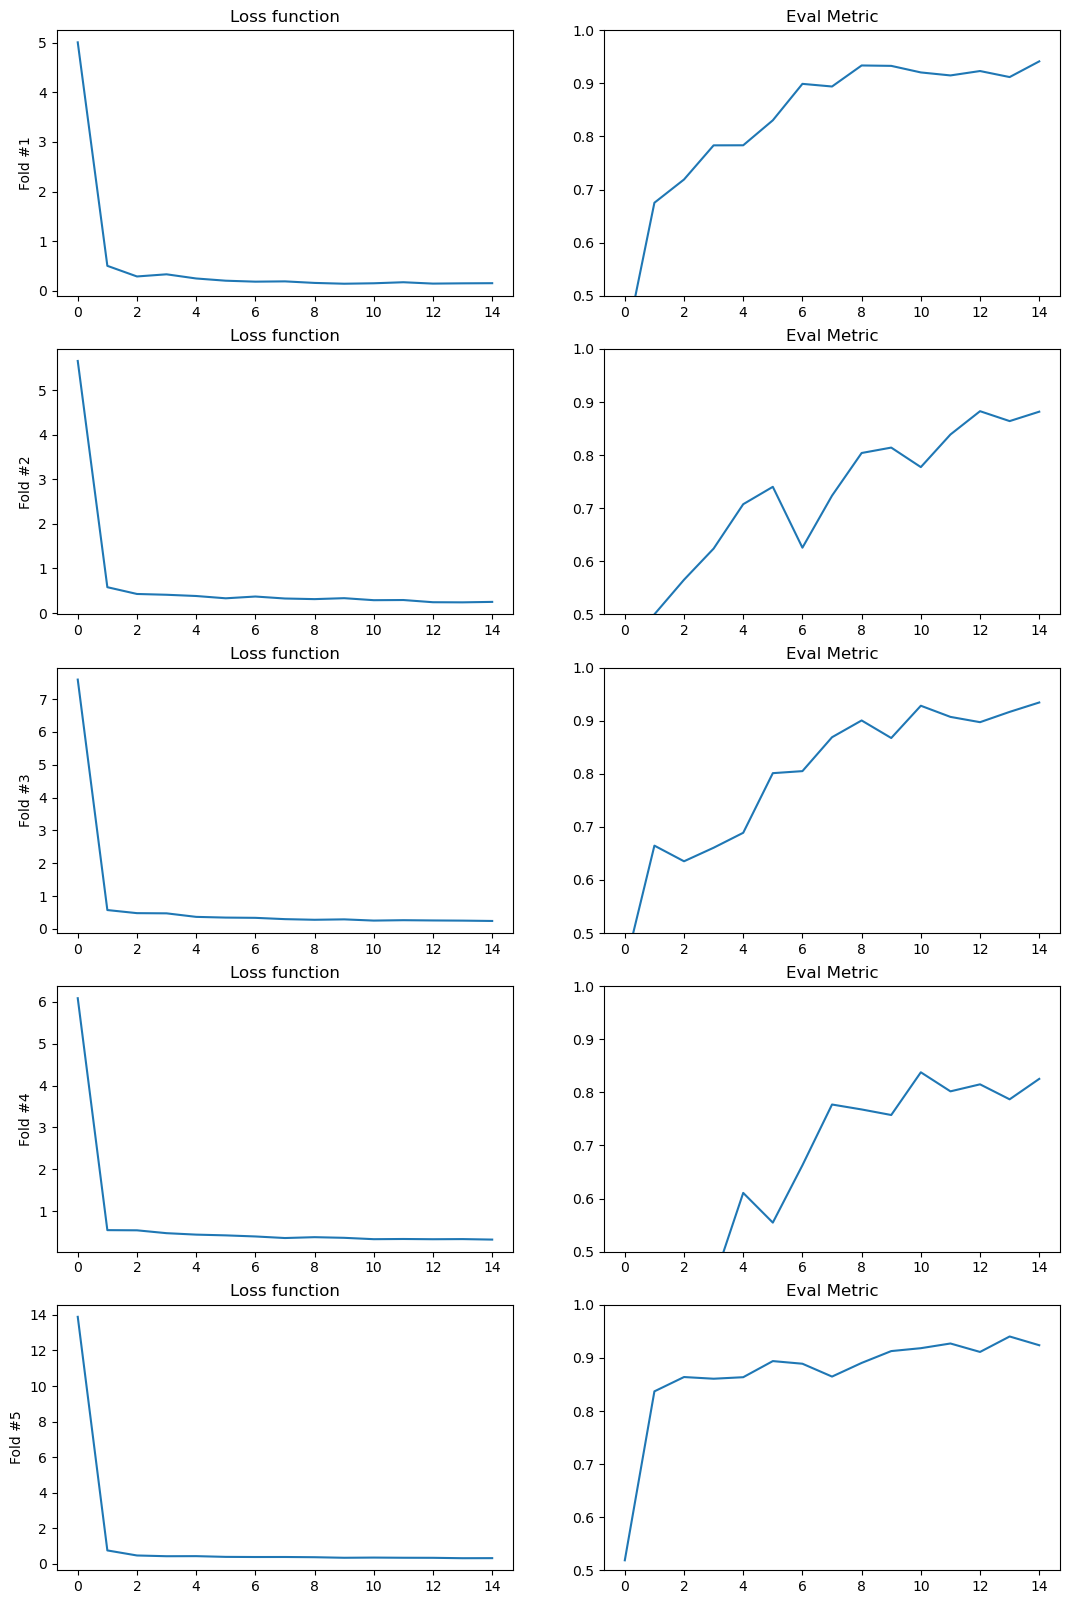

In [12]:
plot_histories(histories_1a)

In [13]:
%%time
# Now lets double the number of conv/pool layers

num_filt_layers = [32,32,64,64]

histories_1b, eval_scores_1b, cnn_1b = build_model_1(optimizer=adam, num_filt_layers=num_filt_layers, l2_lambda=l2_lambda)

Fold 1

Epoch 1/15
10/10 [==============================] - 4s 291ms/step - loss: 0.8702 - f1: 0.5860
Epoch 2/15
10/10 [==============================] - 3s 263ms/step - loss: 0.3198 - f1: 0.7912
Epoch 3/15
10/10 [==============================] - 3s 292ms/step - loss: 0.2210 - f1: 0.8634
Epoch 4/15
10/10 [==============================] - 3s 287ms/step - loss: 0.2143 - f1: 0.8865
Epoch 5/15
10/10 [==============================] - 3s 292ms/step - loss: 0.1694 - f1: 0.9330
Epoch 6/15
10/10 [==============================] - 3s 288ms/step - loss: 0.1517 - f1: 0.9469
Epoch 7/15
10/10 [==============================] - 3s 269ms/step - loss: 0.1532 - f1: 0.9287
Epoch 8/15
10/10 [==============================] - 3s 303ms/step - loss: 0.1479 - f1: 0.9402
Epoch 9/15
10/10 [==============================] - 3s 272ms/step - loss: 0.1422 - f1: 0.9435
Epoch 10/15
10/10 [==============================] - 3s 301ms/step - loss: 0.1532 - f1: 0.9544
Epoch 11/15
10/10 [==============================] 

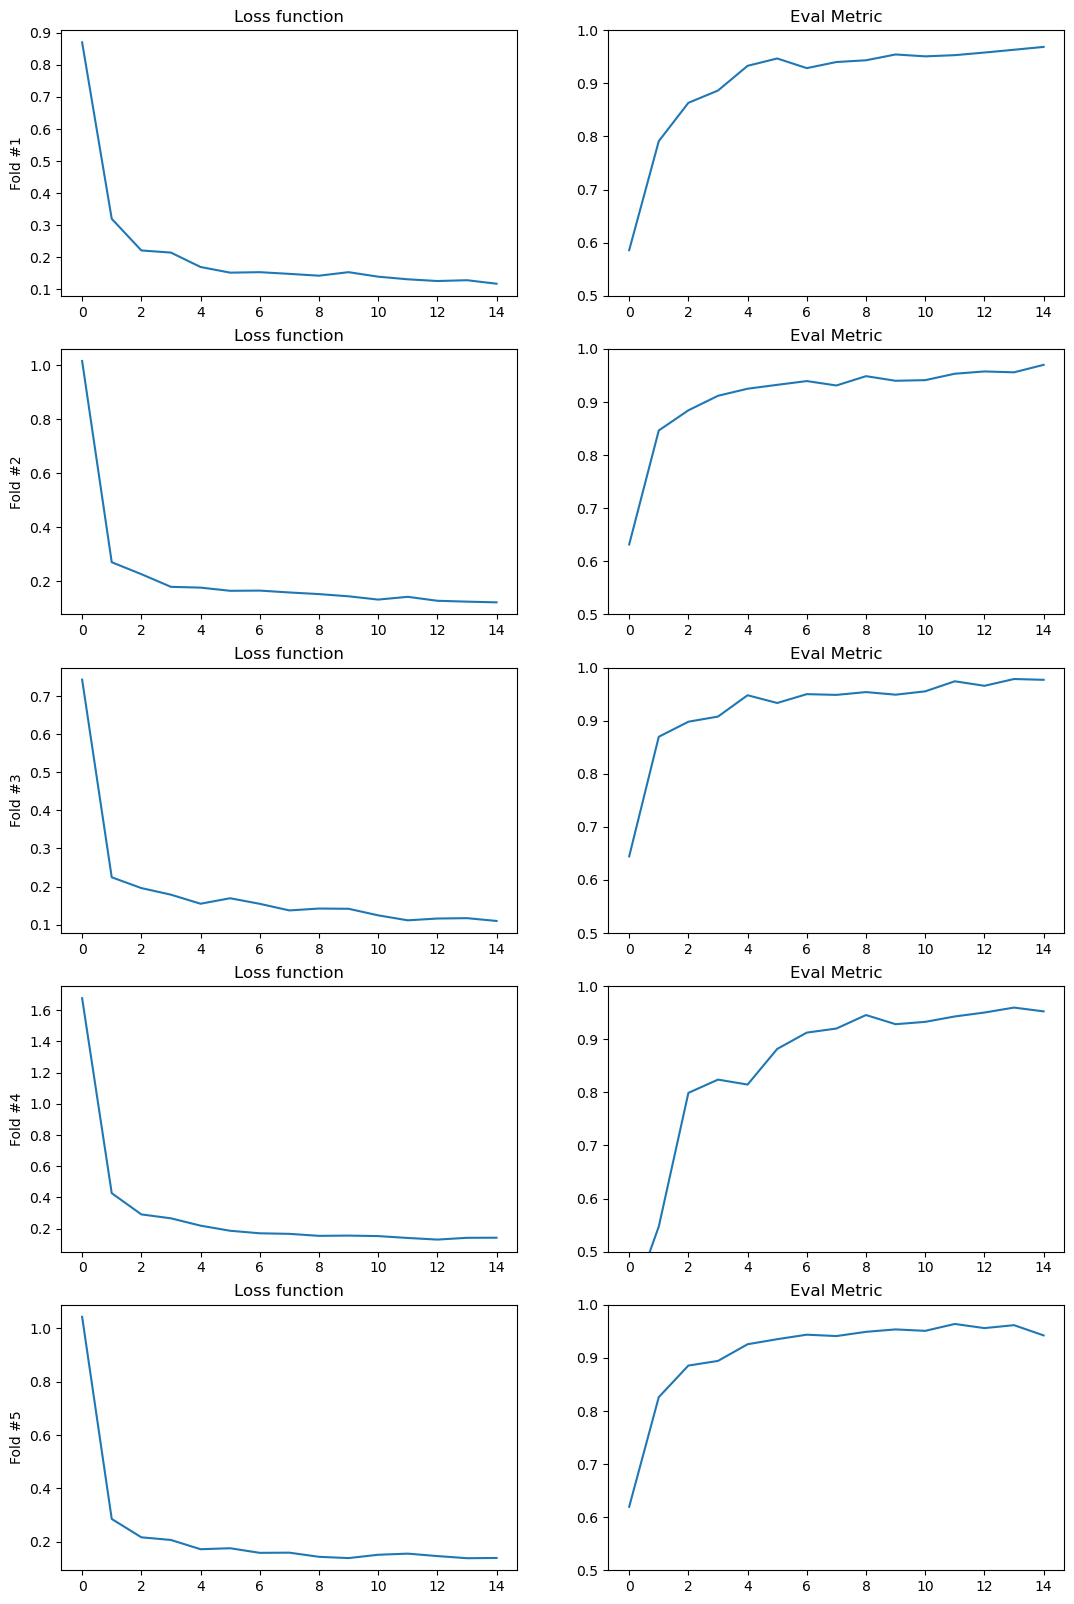

In [14]:
plot_histories(histories_1b)

---
##### By doubling the number of layers, but keeping the same number of filters, our new model variant performs considerably better insofar that we see convergence for each fold and our evaluation metric is comparatively higher for each iteration. Also, run time appears to remain the same. 
---

## Model 2: Alexnet Architecture (changing activation of last layer)

In [15]:
def model_2(optimizer, num_filt_layers, l2_lambda):
    reg = l2(l2_lambda)
    cnn = Sequential()
    
    # Conv 1 - Max Pool 1
    cnn.add( Conv2D(filters=num_filt_layers[0], 
                    kernel_size=(11,11),
                    kernel_initializer='he_uniform', 
                    kernel_regularizer=reg,
                    strides=4,
                    padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(3, 3),
                        strides=2))
    
    # Conv 2 - Max Pool 2
    cnn.add( Conv2D(filters=num_filt_layers[1], 
                kernel_size=(5,5),
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                strides=1,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(3, 3),
                        strides=2))
    
    # Conv3 - No Max Pool
    cnn.add( Conv2D(filters=num_filt_layers[2], 
                kernel_size=(3,3), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                strides=1,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    
    # Conv4 - No Max Pool
    cnn.add( Conv2D(filters=num_filt_layers[3], 
                kernel_size=(3,3), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                strides=1,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    
    # Conv5 - Max Pool 3 - Dropout 1
    cnn.add( Conv2D(filters=num_filt_layers[4], 
                kernel_size=(3,3), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                strides=1,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(3, 3),
                        strides=2))
    cnn.add(Dropout(0.5))


    # Full, connected layers
    cnn.add( Flatten() )
    
    cnn.add( Dropout(0.5) )
    cnn.add(Dense(units=128,
                  activation='relu',
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=reg))
    
    cnn.add( Dropout(0.5) )
    cnn.add(Dense(units=128,
                  activation='relu',
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=reg))
    cnn.add(Dense(units=1,
                  activation='sigmoid', # using sigmoid activation for binary classification instead of softmax
                  kernel_initializer='glorot_uniform',
                  kernel_regularizer=reg))
    
    # Let's train the model 
    cnn.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=[f1])    
    return cnn

In [16]:
def build_model_2(optimizer, l2_lambda,
                  
                  num_filt_layers=[96, 256, 384, 384, 256], # original Alexnet filter params
                  
                  batch_size=128, epochs=15, verbose=1
                 ):
    fold_no = 0
    histories = []
    eval_scores = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cnn = model_2(optimizer, num_filt_layers, l2_lambda)

        print('Fold',fold_no+1)
        print('')
        
        history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train)/batch_size),
                              epochs=epochs, verbose=verbose)        
        
        print('')
        scores = []
        scores = cnn.evaluate(X_test, y_test, verbose=verbose)
        print('-' * 110)

        histories.append(history)
        eval_scores.append(scores)

        fold_no += 1

    eval_scores = np.array(eval_scores)
    print("Average Performance")
    print("Loss:",round(np.mean(eval_scores[:,0]), 5))
    print("F1:",round(np.mean(eval_scores[:,1]), 5))
    
    return histories, eval_scores, cnn

In [17]:
%%time
# Needed to increase epochs because it wasn't converging
histories_2a, eval_scores_2a, cnn_2a = build_model_2(optimizer=adam, l2_lambda=l2_lambda, epochs=20)

Fold 1

Epoch 1/20
10/10 [==============================] - 4s 267ms/step - loss: 1.8235 - f1: 0.4041
Epoch 2/20
10/10 [==============================] - 3s 283ms/step - loss: 0.8691 - f1: 0.7028
Epoch 3/20
10/10 [==============================] - 3s 272ms/step - loss: 0.8674 - f1: 0.7866
Epoch 4/20
10/10 [==============================] - 3s 287ms/step - loss: 0.8464 - f1: 0.8261
Epoch 5/20
10/10 [==============================] - 3s 276ms/step - loss: 0.8256 - f1: 0.8288
Epoch 6/20
10/10 [==============================] - 3s 269ms/step - loss: 0.7928 - f1: 0.8790
Epoch 7/20
10/10 [==============================] - 3s 285ms/step - loss: 0.7646 - f1: 0.9103
Epoch 8/20
10/10 [==============================] - 3s 275ms/step - loss: 0.7256 - f1: 0.9097
Epoch 9/20
10/10 [==============================] - 3s 277ms/step - loss: 0.7371 - f1: 0.9273
Epoch 10/20
10/10 [==============================] - 3s 286ms/step - loss: 0.6944 - f1: 0.9437
Epoch 11/20
10/10 [==============================] 

11/11 [==============================] - 1s 27ms/step - loss: 3.2275 - f1: 0.2531
--------------------------------------------------------------------------------------------------------------
Fold 5

Epoch 1/20
10/10 [==============================] - 4s 290ms/step - loss: 1.5504 - f1: 0.4046
Epoch 2/20
10/10 [==============================] - 3s 277ms/step - loss: 0.9619 - f1: 0.6609
Epoch 3/20
10/10 [==============================] - 3s 275ms/step - loss: 0.8616 - f1: 0.8049
Epoch 4/20
10/10 [==============================] - 3s 294ms/step - loss: 0.8410 - f1: 0.8378
Epoch 5/20
10/10 [==============================] - 3s 278ms/step - loss: 0.8301 - f1: 0.8986
Epoch 6/20
10/10 [==============================] - 3s 277ms/step - loss: 0.8111 - f1: 0.8984
Epoch 7/20
10/10 [==============================] - 3s 289ms/step - loss: 0.8046 - f1: 0.9148
Epoch 8/20
10/10 [==============================] - 3s 277ms/step - loss: 0.7717 - f1: 0.9327
Epoch 9/20
10/10 [=============================

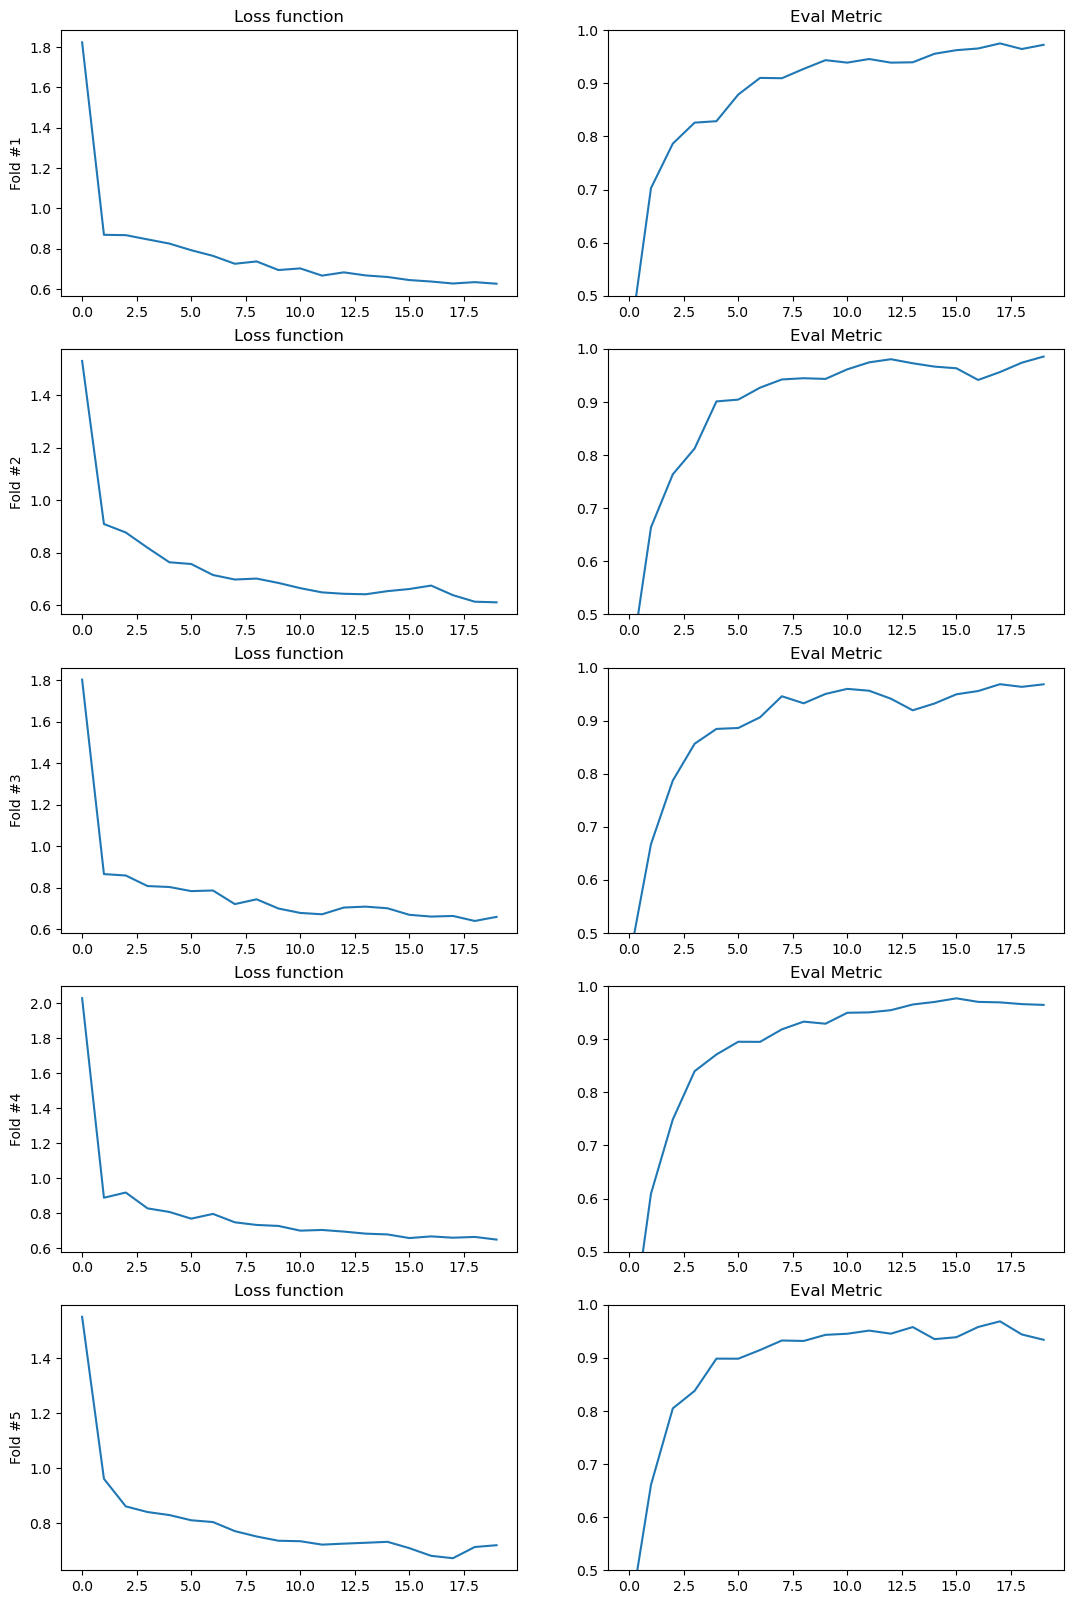

In [18]:
plot_histories(histories_2a)

---
##### Alexnet doesn't perform much greater than our basic cnn (doing just a visual test). Moreover, it actually appears that Alexnet may take a little longer to converge. The eval metrics for both models are comparable, no striking differences. We believe that this is the case because Alexnet was truly optimized for multi-class classification problems, not the simple binary classifier we are attempting to resolve. Nevertheless, let's try to further optimize this model by speeding things up through the utilization of a technique introduced in Inception. We are going to split Alexnet's conv layer 4 into conv layer 4a and conv layer 4b. We will first operate with a (3,1) kernel for 4a then a (1,3) kernel in 4b. This is essentially the same as applying just a single (3,3) kernel in one layer, but should speed up the processing.
---

In [19]:
def model_2_alt(optimizer, num_filt_layers, l2_lambda):
    reg = l2(l2_lambda)
    cnn = Sequential()
    
    # Conv 1 - Max Pool 1
    cnn.add( Conv2D(filters=num_filt_layers[0], 
                    kernel_size=(11,11),
                    kernel_initializer='he_uniform', 
                    kernel_regularizer=reg,
                    strides=4,
                    padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(3, 3),
                        strides=2))
    
    # Conv 2 - Max Pool 2
    cnn.add( Conv2D(filters=num_filt_layers[1], 
                kernel_size=(3,3),
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                strides=1,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(3, 3),
                        strides=2))
    
    # Conv3 - No Max Pool
    cnn.add( Conv2D(filters=num_filt_layers[2], 
                kernel_size=(3,3), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                strides=1,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
#--------------------------------------------------------------------------------------------------#  
    # Let's speed things up
    # (3,3) is the same as first doing a (1,3) then a (3,1) - based on the work done on Inception
    # Conv4a - No Max Pool
    cnn.add( Conv2D(filters=num_filt_layers[3], 
                kernel_size=(1,3), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                strides=1,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())

    # Conv4b - No Max Pool
    cnn.add( Conv2D(filters=num_filt_layers[3], 
                kernel_size=(3,1), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                strides=1,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    # Finish speed up process
#--------------------------------------------------------------------------------------------------#     
    # Conv5 - Max Pool 3 - Dropout 1
    cnn.add( Conv2D(filters=num_filt_layers[4], 
                kernel_size=(3,3), 
                kernel_initializer='he_uniform', 
                kernel_regularizer=reg,
                strides=1,
                padding='same',))
    cnn.add( Activation('relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(3, 3),
                        strides=2))
    cnn.add(Dropout(0.5))


    # Full, connected layers
    cnn.add( Flatten() )
    
    cnn.add( Dropout(0.5) )
    cnn.add(Dense(units=128,
                  activation='relu',
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=reg))
    
    cnn.add( Dropout(0.5) )
    cnn.add(Dense(units=128,
                  activation='relu',
                  kernel_initializer='he_uniform', 
                  kernel_regularizer=reg))
    cnn.add(Dense(units=1,
                  activation='sigmoid', # using sigmoid activation for binary classification instead of softmax
                  kernel_initializer='glorot_uniform',
                  kernel_regularizer=reg))
    
    # Let's train the model 
    cnn.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=[f1])    
    return cnn

In [20]:
def build_model_2_alt(optimizer, l2_lambda,
                  
                  num_filt_layers=[96, 256, 384, 384, 256], # original Alexnet filter params
                  
                  batch_size=128, epochs=15, verbose=1
                 ):
    fold_no = 0
    histories = []
    eval_scores = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cnn = model_2_alt(optimizer, num_filt_layers, l2_lambda)

        print('Fold',fold_no+1)
        print('')
        
        history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train)/batch_size),
                              epochs=epochs, verbose=verbose)        
        
        print('')
        scores = []
        scores = cnn.evaluate(X_test, y_test, verbose=verbose)
        print('-' * 110)

        histories.append(history)
        eval_scores.append(scores)

        fold_no += 1

    eval_scores = np.array(eval_scores)
    print("Average Performance")
    print("Loss:",round(np.mean(eval_scores[:,0]), 5))
    print("F1:",round(np.mean(eval_scores[:,1]), 5))
    
    return histories, eval_scores, cnn

In [21]:
histories_2b, eval_scores_2b, cnn_2b = build_model_2_alt(optimizer=adam, l2_lambda=l2_lambda, epochs=20)

Fold 1

Epoch 1/20
10/10 [==============================] - 3s 210ms/step - loss: 2.2086 - f1: 0.3759
Epoch 2/20
10/10 [==============================] - 2s 234ms/step - loss: 0.9506 - f1: 0.6125
Epoch 3/20
10/10 [==============================] - 2s 217ms/step - loss: 0.9330 - f1: 0.7576
Epoch 4/20
10/10 [==============================] - 2s 205ms/step - loss: 0.8503 - f1: 0.8589
Epoch 5/20
10/10 [==============================] - 2s 225ms/step - loss: 0.7947 - f1: 0.9103
Epoch 6/20
10/10 [==============================] - 2s 223ms/step - loss: 0.8231 - f1: 0.9071
Epoch 7/20
10/10 [==============================] - 2s 206ms/step - loss: 0.7627 - f1: 0.9336
Epoch 8/20
10/10 [==============================] - 2s 236ms/step - loss: 0.7646 - f1: 0.9327
Epoch 9/20
10/10 [==============================] - 2s 214ms/step - loss: 0.7386 - f1: 0.9465
Epoch 10/20
10/10 [==============================] - 2s 211ms/step - loss: 0.7424 - f1: 0.9412
Epoch 11/20
10/10 [==============================] 

11/11 [==============================] - 0s 21ms/step - loss: 11.6034 - f1: 0.2517
--------------------------------------------------------------------------------------------------------------
Fold 5

Epoch 1/20
10/10 [==============================] - 3s 207ms/step - loss: 1.6058 - f1: 0.4254
Epoch 2/20
10/10 [==============================] - 2s 227ms/step - loss: 1.0318 - f1: 0.6584
Epoch 3/20
10/10 [==============================] - 2s 222ms/step - loss: 0.8910 - f1: 0.8280
Epoch 4/20
10/10 [==============================] - 2s 220ms/step - loss: 0.8492 - f1: 0.8853
Epoch 5/20
10/10 [==============================] - 2s 214ms/step - loss: 0.8329 - f1: 0.9012
Epoch 6/20
10/10 [==============================] - 2s 216ms/step - loss: 0.8042 - f1: 0.9225
Epoch 7/20
10/10 [==============================] - 2s 205ms/step - loss: 0.7733 - f1: 0.9375
Epoch 8/20
10/10 [==============================] - 2s 218ms/step - loss: 0.7700 - f1: 0.9405
Epoch 9/20
10/10 [============================

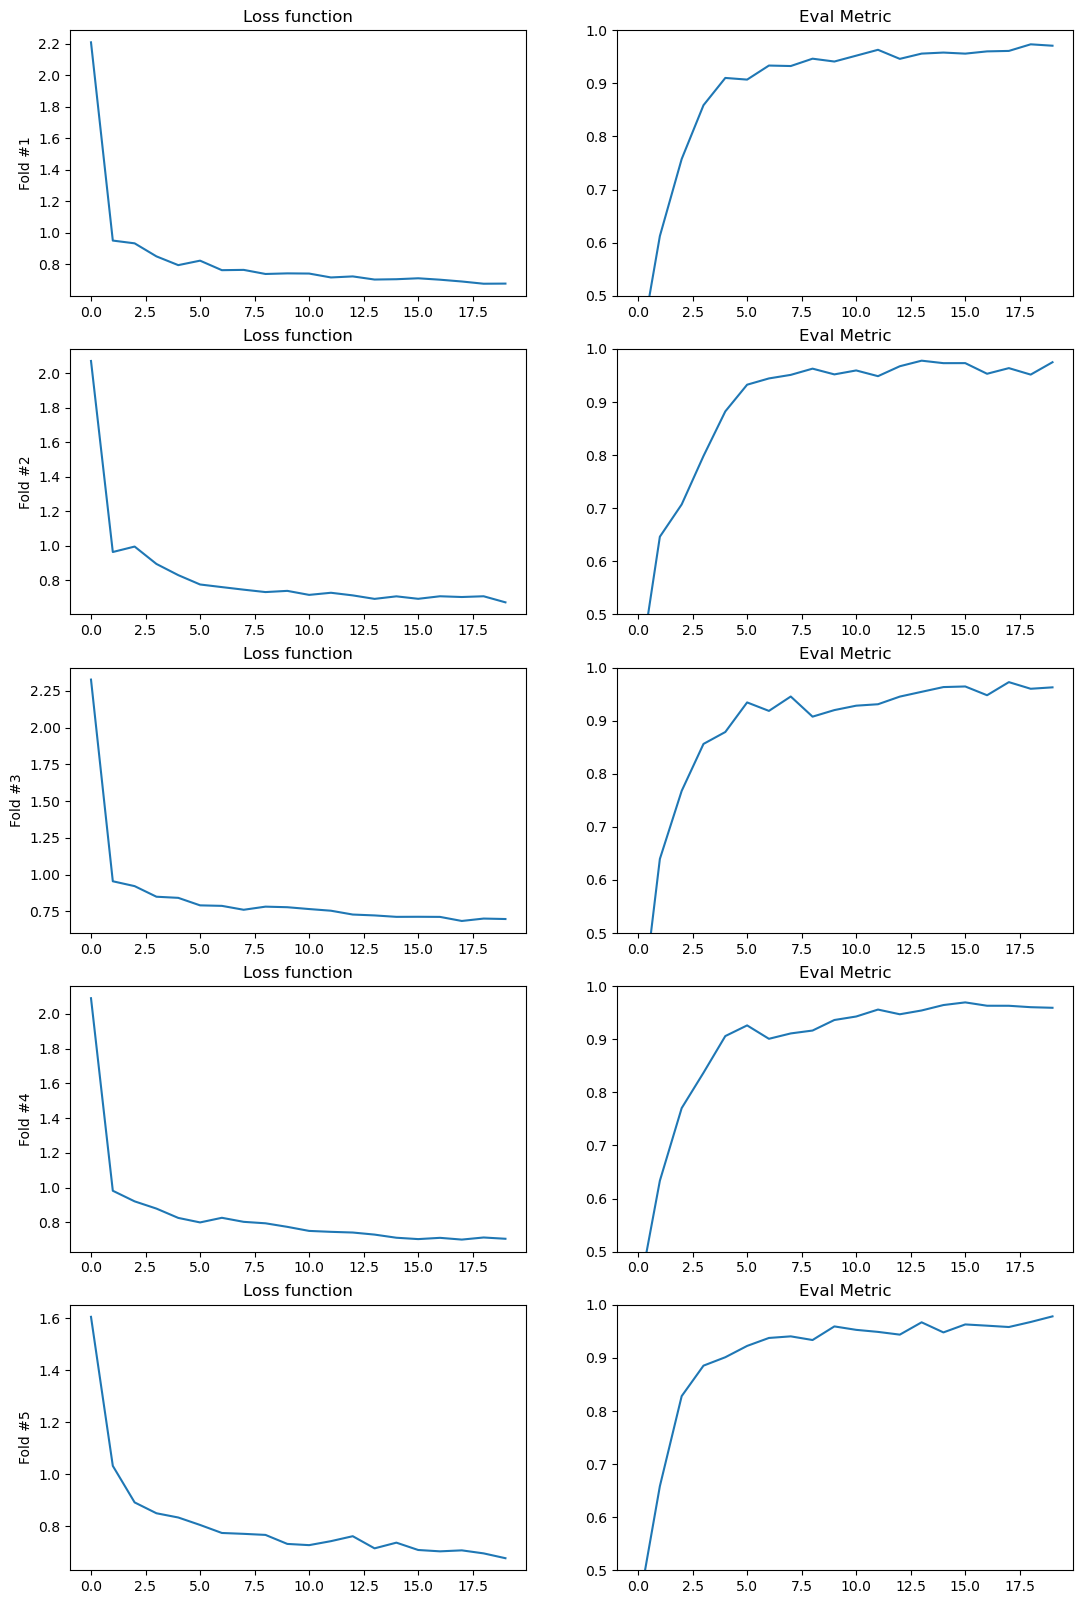

In [22]:
plot_histories(histories_2b)

---
##### It looks like we sped up the processing while reducing the time it took for the model to converge. Eval metrics remain similar. As a note, my computer runs the slowest out of our group. Other group members see results twice as fast for each of the models. All in all, our models look good based on the f1 scores we get per epoch within each fold (almost every fold within each model converges well above 0.9).
---

## Visualizing CNN Results

In [23]:
# Let's begin by summarizing each of our models
cnn_1a.summary() # basic cnn

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, None, None, 32)    320       
                                                                 
 activation_8 (Activation)   (None, None, None, 32)    0         
                                                                 
 batch_normalization_8 (Batc  (None, None, None, 32)   128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, None, None, 32)   0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 activation_9 (Activation)   (None, None, None, 64)   

In [24]:
cnn_1b.summary() # basic cnn -- now doubled conv/pool layers

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, None, None, 32)    320       
                                                                 
 activation_26 (Activation)  (None, None, None, 32)    0         
                                                                 
 batch_normalization_26 (Bat  (None, None, None, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, None, None, 32)   0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, None, None, 32)    9248      
                                                                 
 activation_27 (Activation)  (None, None, None, 32)   

In [25]:
cnn_2a.summary() # Alexnet

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, None, None, 96)    11712     
                                                                 
 activation_50 (Activation)  (None, None, None, 96)    0         
                                                                 
 batch_normalization_50 (Bat  (None, None, None, 96)   384       
 chNormalization)                                                
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, None, None, 96)   0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, None, None, 256)   614656    
                                                                 
 activation_51 (Activation)  (None, None, None, 256) 

In [26]:
cnn_2b.summary() # Alexnet -- sped up by Inception

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_79 (Conv2D)          (None, None, None, 96)    11712     
                                                                 
 activation_79 (Activation)  (None, None, None, 96)    0         
                                                                 
 batch_normalization_79 (Bat  (None, None, None, 96)   384       
 chNormalization)                                                
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, None, None, 96)   0         
 g2D)                                                            
                                                                 
 conv2d_80 (Conv2D)          (None, None, None, 256)   221440    
                                                                 
 activation_80 (Activation)  (None, None, None, 256) 

In [27]:
# Next let's take a look at the average scores for each fold within each model
all_histories = [histories_1a, histories_1b, histories_2a, histories_2b]
scores = []
for model_histories in all_histories:
    score_i = []
    for fold_no, history in enumerate(model_histories):
        keys = list(history.history.keys())  
        score_i.append(np.mean(history.history[keys[1]]))
    scores.append(score_i)
scores = np.array(scores)
for i in range(len(scores)):
    print('Model ' + str(i+1) + ' average score per fold is: ' + str(scores[i,:]))

Model 1 average score per fold is: [0.83104378 0.7128402  0.79393529 0.65139649 0.86768179]
Model 2 average score per fold is: [0.90453628 0.91122613 0.92342749 0.84680477 0.9098798 ]
Model 3 average score per fold is: [0.88393322 0.8933079  0.88895339 0.87961744 0.88537501]
Model 4 average score per fold is: [0.88868763 0.88976832 0.87970565 0.88651757 0.89896102]


In [28]:
cnn_1a_scores = scores[0,:]; cnn_1b_scores = scores[1,:]; cnn_2a_scores = scores[2,:]; cnn_2b_scores = scores[3,:]

## Compare CNN to MLP

In [59]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# helper function from class notebook
def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    
    yhat_cnn = np.round(cnn.predict(X_test))
    fpr_cnn, tpr_cnn, _ = roc_curve(y_test[:,0], yhat_cnn[:,0])
    auc_cnn = auc(fpr_cnn, tpr_cnn)
    
    yhat_mlp = np.round(mlp.predict(X_test))
    fpr_mlp, tpr_mlp, _ = roc_curve(y_test[:,0], yhat_mlp[:,0])
    auc_mlp = auc(fpr_mlp, tpr_mlp)
    
    plt.figure(figsize=(8,8))
    plt.plot(fpr_cnn, tpr_cnn, color='red', label=r'CNN ROC (AUC = %0.2f )' % (auc_cnn), lw=2, alpha=1)
    plt.plot(fpr_mlp, tpr_mlp, color='green', label=r'MLP ROC (AUC = %0.2f )' % (auc_mlp), lw=2, alpha=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

In [61]:
def model_mlp():
    # make a 3 layer keras MLP
    mlp = Sequential()
    
    mlp.add(Input(shape=(100, 100, 1)))
    mlp.add(Flatten())

    mlp.add(Dense(units=128, activation='relu'))
    mlp.add(Dropout(0.25))
    mlp.add(Dense(units=128, activation='relu'))
    mlp.add(Dropout(0.4))
    mlp.add(Dense(units=64, activation='relu'))
    mlp.add(Dense(units=32, activation='relu'))
    mlp.add(Dense(units=2, activation='sigmoid'))

    mlp.compile(optimizer=Adam(),
                loss='binary_crossentropy',
                metrics=[f1])
    mlp.summary()
    
    return mlp


In [62]:
def build_mlp_cnn(optimizer, l2_lambda,
                  
                  num_filt_layers=[96, 256, 384, 384, 256], # original Alexnet filter params
                  
                  batch_size=128, epochs=15, verbose=1
                 ):
    fold_no = 0
    histories = []
    eval_scores = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        cnn = model_2_alt(optimizer, num_filt_layers, l2_lambda)
        mlp = model_mlp()

        print('Fold',fold_no+1)
        print('')
        
        hist_cnn = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                            steps_per_epoch=int(len(X_train)/batch_size),
                              epochs=epochs, verbose=verbose)
        
        hist_mlp = mlp.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                steps_per_epoch=int(len(X_train)/batch_size),
                epochs=epochs,
                verbose=verbose,
                validation_data=(X_test,y_test))
        
        compare_mlp_cnn(cnn,mlp,X_test,y_test)

In [63]:
build_mlp_cnn(optimizer=adam, l2_lambda=l2_lambda, epochs=20)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_29 (Flatten)        (None, 10000)             0         
                                                                 
 dense_83 (Dense)            (None, 128)               1280128   
                                                                 
 dropout_74 (Dropout)        (None, 128)               0         
                                                                 
 dense_84 (Dense)            (None, 128)               16512     
                                                                 
 dropout_75 (Dropout)        (None, 128)               0         
                                                                 
 dense_85 (Dense)            (None, 64)                8256      
                                                                 
 dense_86 (Dense)            (None, 32)              

ValueError: in user code:

    File "C:\Users\Kirk\anaconda3\envs\tensorflow_env2\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Kirk\anaconda3\envs\tensorflow_env2\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Kirk\anaconda3\envs\tensorflow_env2\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Kirk\anaconda3\envs\tensorflow_env2\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Kirk\anaconda3\envs\tensorflow_env2\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Kirk\anaconda3\envs\tensorflow_env2\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Kirk\anaconda3\envs\tensorflow_env2\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Kirk\anaconda3\envs\tensorflow_env2\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Kirk\anaconda3\envs\tensorflow_env2\lib\site-packages\keras\losses.py", line 1930, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\Kirk\anaconda3\envs\tensorflow_env2\lib\site-packages\keras\backend.py", line 5283, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((None, 2) vs (None, 1)).
